## Hybrid QNN with PyTorch (Convolutional network)

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import *

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [3]:
fano_data = pd.read_csv("../datasets/signal_080_peak_1_fano_adjust.csv")

In [4]:
def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

def scale(arr, lvalue = -np.pi, rvalue = np.pi):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))

def remove_outlier(df_in, col_name, quartiles, rng_arr):
    q1 = df_in[col_name].quantile(quartiles[0])
    q3 = df_in[col_name].quantile(quartiles[1])
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-rng_arr[0]*iqr
    fence_high = q3+rng_arr[1]*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [5]:
def smooth(data):
    #return data
    #return scipy.ndimage.gaussian_filter(data, sigma=30, mode='reflect', truncate=18.0)
    
    return gaussian_filter(data, sigma=15, mode='reflect', truncate=18.0)
    #return scipy.ndimage.gaussian_filter(data, sigma=15, mode='reflect', truncate=15.0)

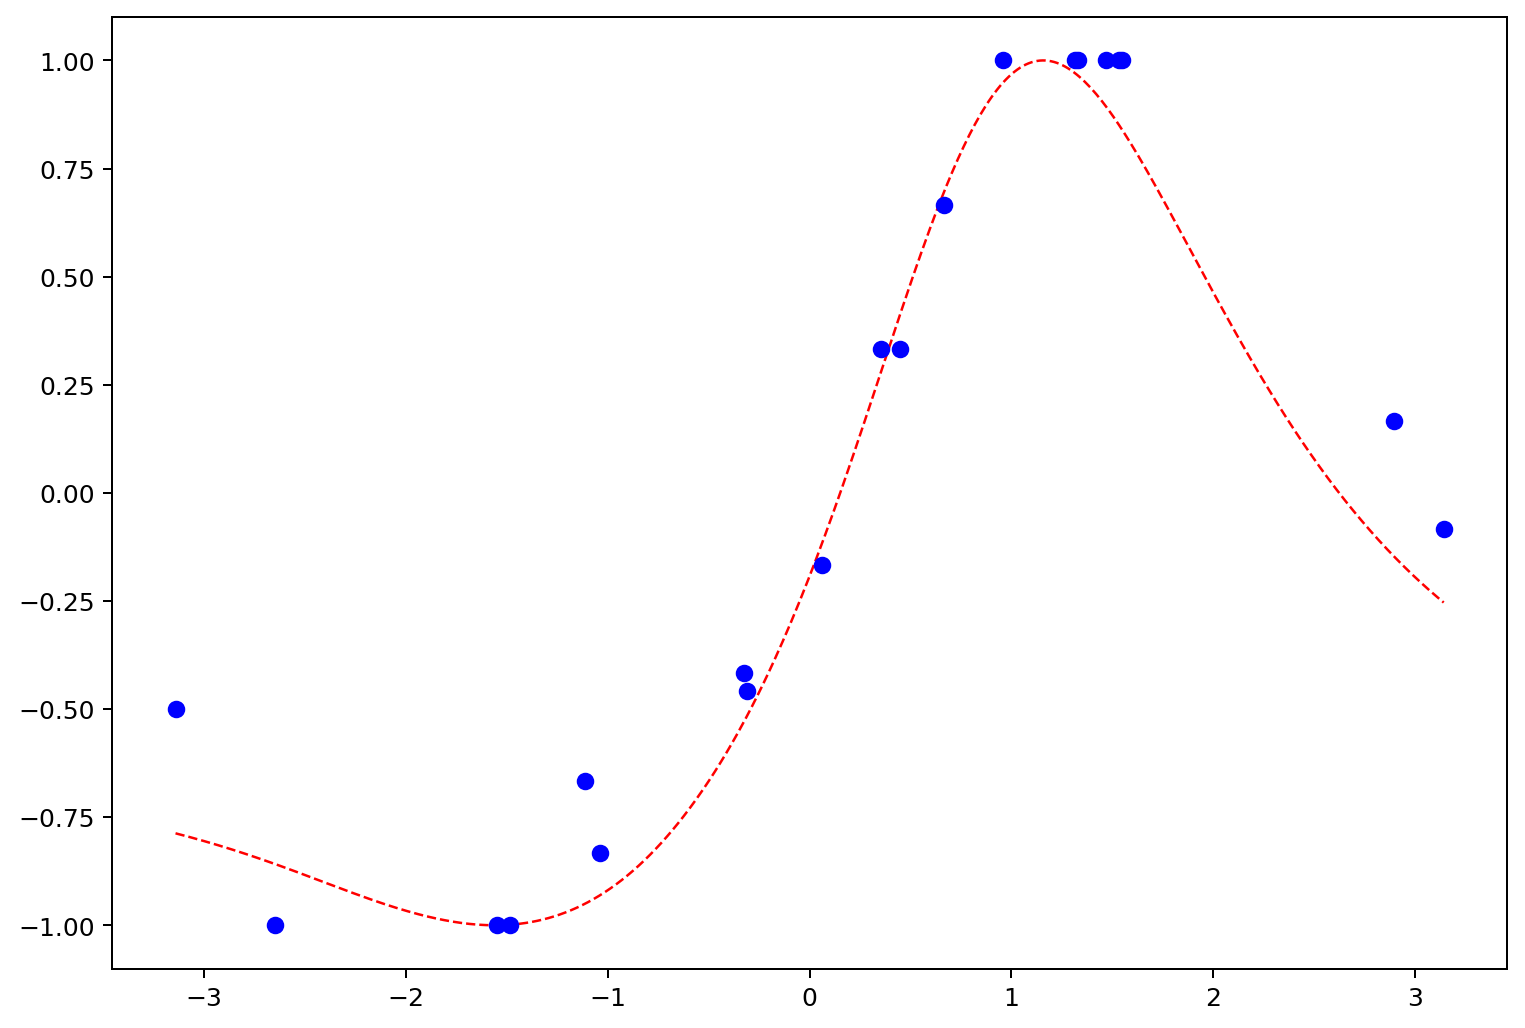

In [6]:
num_samples = 20
eps = 0.2
lb, ub = -1, 1

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)

# Create Gaussian distribution (mean = 0, std = 1)
std_scaler = StandardScaler()
std_scaler.fit(X_)
X_ = std_scaler.transform(X_)

#y_ = f(X_)

y_ = fano_data["signal_original_y"].values

# select a better range of data to fit
rng = range(250,700)

X_ = X_.take(rng, axis=0)
y_ = y_.take(rng, axis=0)

# random indices for points selection
#indices = sorted(np.random.choice(range(X_.shape[0]), num_samples, replace=False))

#indices = np.array([19,  40, 156, 159, 173, 175, 191, 207, 213, 253, 358, 359, 448, 543, 559, 613, 651, 657, 737, 754])
indices = [22, 54, 125, 129, 153, 158, 204, 205, 229, 248, 254, 268, 287, 310, 311, 320, 324, 325, 412, 428]

X = X_[indices].reshape(-1,1)
y = y_[indices].reshape(-1,1)

#df = pd.DataFrame(zip(X[:,0].flatten().tolist(), y[:,0].flatten().tolist()), columns = ["X", "y"])
#new_df = remove_outlier(df, "y", [0.25, 0.75], [0.05, 0.05])
#X = new_df["X"].values.reshape(-1,1)
#y = new_df["y"].values.reshape(-1,1)

y = detrend(y)

X = scale(X)
y = scale(y, -1, 1)

X_ = scale(X_)
y_ = scale(y_, -1, 1)

plt.figure(num = "Fano adjust data", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X_, y_, "r--", label='Tx signal', linewidth = 1)
plt.plot(X, y, "bo", label = 'Points to fit')
plt.show()

In [7]:
class Polyfit(nn.Module):
    
    def __init__(self, input_size):
        super(Polyfit, self).__init__()
        
        self.linear = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=1)
        )
        
    def forward(self, x):
         return self.linear(x)

In [8]:
inputDim = 1        # takes variable 'x' 
outputDim = 1       # takes variable 'y'
learningRate = 0.01 
epochs = 100

model = Polyfit(inputDim)

##### For GPU #######
if torch.cuda.is_available():
    model.cuda()
    print("Cuda available!")
else:
    print("Cuda not available!")

Cuda not available!


In [13]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [14]:
train_x = Variable(torch.from_numpy(X).float())
train_y = Variable(torch.from_numpy(y).float())

dataset_train = TensorDataset(train_x, train_y)

train_dataloader = DataLoader(dataset_train, batch_size = 1)

In [33]:
test_x = Variable(torch.from_numpy(X_).float())
test_y = Variable(torch.from_numpy(y_).float())

dataset_test = TensorDataset(test_x, test_y)

test_dataloader = DataLoader(dataset_test, batch_size = 1)

In [54]:
loss_list = []
acc = []
for epoch in range(epochs):

    total_loss = []
        
    for batch_idx, (data, target) in enumerate(train_dataloader):
        
        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(data)
        
        # get loss for the predicted output
        loss = criterion(outputs, target)
        #print(loss)
        
        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

        total_loss.append(loss.item())
    
    loss_list.append(sum(total_loss)/len(total_loss))
    
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))

Training [1%]	Loss: 0.0069
Training [2%]	Loss: 0.0068
Training [3%]	Loss: 0.0068
Training [4%]	Loss: 0.0068
Training [5%]	Loss: 0.0067
Training [6%]	Loss: 0.0067
Training [7%]	Loss: 0.0067
Training [8%]	Loss: 0.0067
Training [9%]	Loss: 0.0066
Training [10%]	Loss: 0.0066
Training [11%]	Loss: 0.0066
Training [12%]	Loss: 0.0066
Training [13%]	Loss: 0.0066
Training [14%]	Loss: 0.0065
Training [15%]	Loss: 0.0065
Training [16%]	Loss: 0.0065
Training [17%]	Loss: 0.0064
Training [18%]	Loss: 0.0064
Training [19%]	Loss: 0.0064
Training [20%]	Loss: 0.0064
Training [21%]	Loss: 0.0064
Training [22%]	Loss: 0.0063
Training [23%]	Loss: 0.0063
Training [24%]	Loss: 0.0063
Training [25%]	Loss: 0.0063
Training [26%]	Loss: 0.0062
Training [27%]	Loss: 0.0062
Training [28%]	Loss: 0.0062
Training [29%]	Loss: 0.0062
Training [30%]	Loss: 0.0062
Training [31%]	Loss: 0.0061
Training [32%]	Loss: 0.0061
Training [33%]	Loss: 0.0061
Training [34%]	Loss: 0.0060
Training [35%]	Loss: 0.0060
Training [36%]	Loss: 0.0060
T

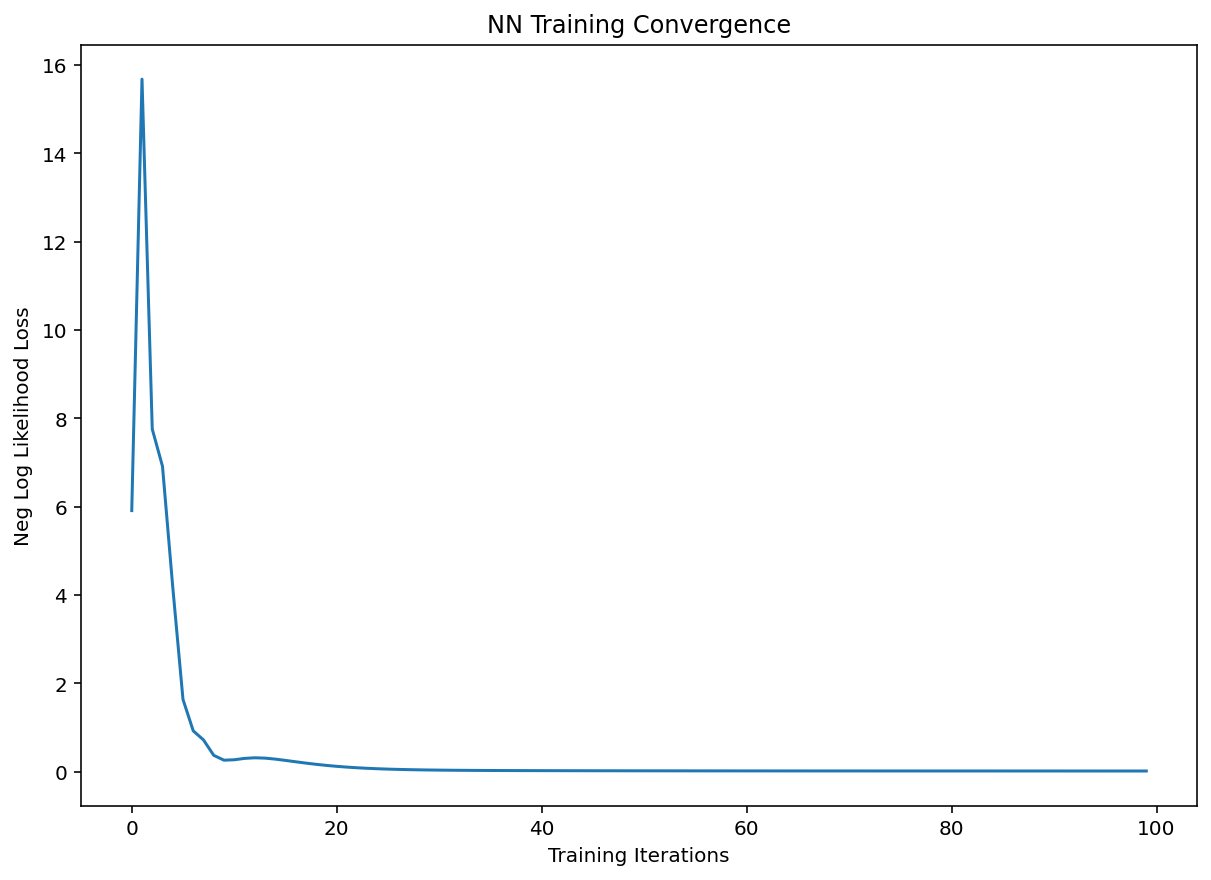

In [17]:
plt.plot(loss_list)
plt.title('NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')
plt.show()

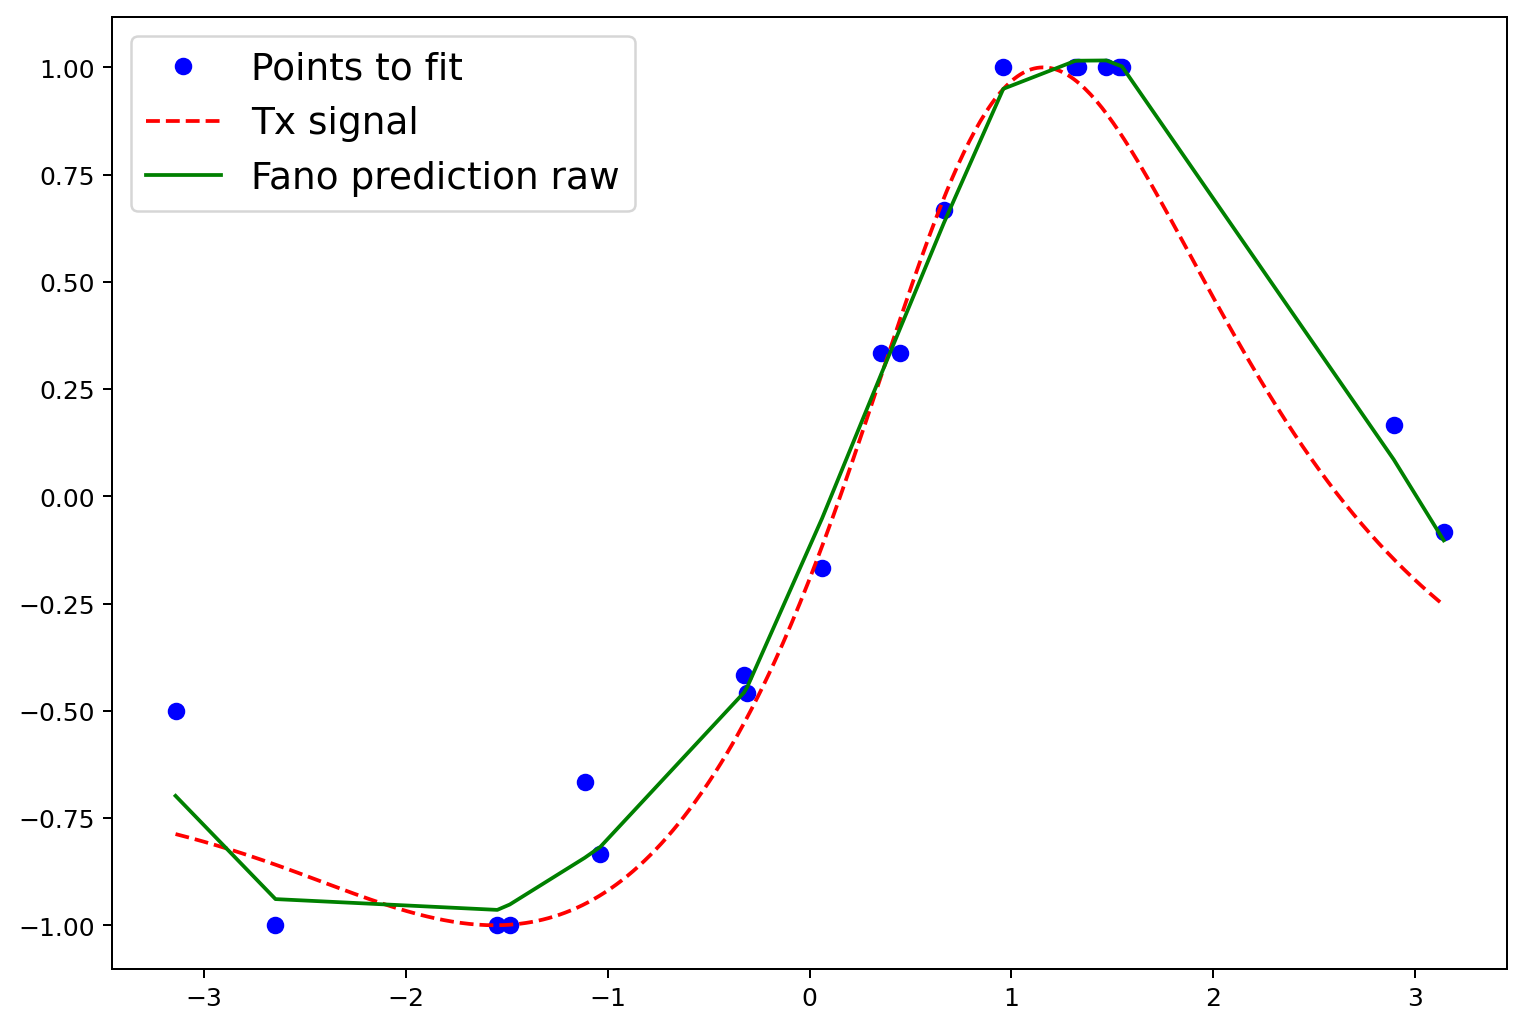

In [50]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(X, y, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot fitted line
y_predict = model(train_x).detach().numpy()
#y_predict_smooth = smooth(y_predict)
plt.plot(X, y_predict[:,0], "g-", label = 'Fano prediction raw')
#plt.plot(X, y_predict_smooth[:,0], "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')

plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [102]:
acc = []

for epoch in range(epochs):
    
    correct = 0
    
    for batch_idx, (data, target) in enumerate(test_dataloader):
        
        outputs = model(data)
     
        max_item , _ = torch.max(outputs.data, 1)
 
        correct = correct + (abs(max_item - target) < 0.3).sum().item()
        
    accuracy = correct / len(test_dataloader)
    acc.append(accuracy)
    
print("Accuracy: {:.4f}".format(np.array(acc).mean()))

Accuracy: 0.8644


In [20]:
import qiskit.tools.jupyter
%qiskit_version_table